In [1]:
import os
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandana as pdna
import pandas as pd

In [2]:
data_path = Path(os.environ["DATA_PATH"])
census_path = Path(os.environ["CENSUS_PATH"])
population_grids_path = Path(os.environ["POPULATION_GRIDS_PATH"])
geostatistical_framework_path = Path(os.environ["GEOSTATISTICAL_FRAMEWORK_PATH"])
results_path = Path("./results")

In [3]:
ADJUSTMENT_FACTOR = 3
WALK_SPEED = 5  # km/h
MAX_DISTANCE = 5_000  # aprox 1 hour of walking
NUM_POIS = 5

EQUIPAMIENTOS = {
    "guarderia": {"radius": 750},
    "preescolar": {"radius": 750},
    "primaria": {"radius": 500},
    "secundaria": {"radius": 1_000},
    "preparatoria": {"radius": 5_000},
    "universidad": {"radius": 50_000},
    "parque": {"radius": 670},
    "auditorio": {"radius": 1_000},
    "biblioteca": {"radius": 10_000},
    "cine": {"radius": 1_500},
    "unidad_deportiva": {"radius": 10_000},
    "hospital": {"radius": 50_000},
    "centro_salud": {"radius": 1_000},
}

In [4]:
def process_gdf(path: str):
    return (
        gpd.read_file(data_path / path)
        .reset_index(drop=True)
        .filter(["geometry"])
        .to_crs("EPSG:6372")
    )


df_guarderia = process_gdf("datos/Guarderias/Guarderias.shp").assign(
    equipamiento="guarderia",
)
df_preescolar = process_gdf("datos/PreescolarWgs84/PreescolarWgs84.shp").assign(
    equipamiento="preescolar",
)
df_primaria = process_gdf("datos/PrimariasWgs84/PrimariasWgs84.shp").assign(
    equipamiento="primaria",
)
df_secundaria = process_gdf("datos/Secundarias_Wgs84/Secundarias_Wgs84.shp").assign(
    equipamiento="secundaria",
)
df_preparatoria = process_gdf(
    "datos/Preparatorias_Wgs84/Preparatorias_Wgs84.shp",
).assign(equipamiento="preparatoria")
df_universidad = process_gdf("datos/Superior_Wgs84/Superior_Wgs84.shp").assign(
    equipamiento="universidad",
)
df_parque = process_gdf("datos/pparquesWgs84/pparquesWgs84.shp").assign(
    equipamiento="parque",
)
df_auditorio = process_gdf("datos/Auditorios_Wgs84/Auditorios_Wgs84.shp").assign(
    equipamiento="auditorio",
)
df_biblioteca = process_gdf("datos/Bibliotecas/BibliotecasWgs84.shp").assign(
    equipamiento="biblioteca",
)
df_cine = process_gdf("datos/cinesWGS84/cinesWGS84.shp").assign(equipamiento="cine")
df_unidad_deportiva = process_gdf(
    "datos/Uni_DeportivasWgs84/Uni_DeportivasWgs84.shp",
).assign(equipamiento="unidad_deportiva")
gdf_unidad_medica = (
    gpd.read_file(data_path / "datos/Unidad_Medica_Wgs84/Unidad_Medica_Wgs84.shp")
    .assign(equipamiento="unidad_medica")
    .reset_index(drop=True)
    .to_crs("EPSG:6372")
)
salud_equipamientos = {
    "CLÍNICA": "centro_salud",
    "HOSPITAL": "hospital",
    "CENTRO DE SALUD": "centro_salud",
}
gdf_unidad_medica = gdf_unidad_medica[
    (gdf_unidad_medica["CATEGORIA"] == "PÚBLICO")
    & (gdf_unidad_medica["TIPO"].isin(salud_equipamientos.keys()))
]
gdf_unidad_medica["equipamiento"] = gdf_unidad_medica["TIPO"].map(salud_equipamientos)
gdf_unidad_medica = gdf_unidad_medica.filter(["geometry", "equipamiento"])

df_equipamientos = pd.concat(
    [
        df_guarderia,
        df_preescolar,
        df_primaria,
        df_secundaria,
        df_preparatoria,
        df_universidad,
        df_parque,
        df_auditorio,
        df_biblioteca,
        df_cine,
        df_unidad_deportiva,
        gdf_unidad_medica,
    ],
)
df_equipamientos["capacity"] = 1
df_equipamientos = gpd.GeoDataFrame(
    df_equipamientos,
    geometry="geometry",
    crs="EPSG:6372",
)
df_equipamientos["geometry"] = df_equipamientos.centroid
df_equipamientos.head()

,geometry,equipamiento,capacity
0,POINT (2078072.038 2189348.874),guarderia,1
1,POINT (2083880.276 2181248.302),guarderia,1
2,POINT (2085036.549 2181192.865),guarderia,1
3,POINT (2081444.276 2181347.528),guarderia,1
4,POINT (2080421.538 2182165.071),guarderia,1


In [5]:
df_census_base = pd.read_csv(
    census_path / "2020" / "08.csv",
    usecols=[
        "ENTIDAD",
        "MUN",
        "LOC",
        "AGEB",
        "MZA",
        "NOM_LOC",
        "POBTOT",
        "P_0A2",
        "P_3A5",
        "P_60YMAS",
        "P18YM_PB",
        "P_18YMAS",
        "GRAPROES",
        "TVIVPARHAB",
        "PRO_OCUP_C",
        "VPH_PISODT",
        "VPH_C_ELEC",
        "VPH_REFRI",
        "VPH_LAVAD",
        "VPH_HMICRO",
        "VPH_NDACMM",
    ],
)

In [6]:
df_geom_agebs = (
    gpd.read_file(
        population_grids_path / "final/zone_agebs/shaped/2020/08.2.03.gpkg",
    )
    .drop(columns=["POBTOT"])
    .rename(columns={"CVEGEO": "id"})
    .set_index("id")
)

df_census_agebs = (
    df_census_base.query("NOM_LOC == 'Total AGEB urbana'")
    .assign(
        CVEGEO=lambda df: (
            df["ENTIDAD"].astype(str).str.zfill(2)
            + df["MUN"].astype(str).str.zfill(3)
            + df["LOC"].astype(str).str.zfill(4)
            + df["AGEB"].astype(str).str.zfill(4)
        ),
    )
    .drop(columns=["ENTIDAD", "MUN", "LOC", "AGEB", "NOM_LOC"])
    .set_index("CVEGEO")
    .replace("*", np.nan)
    .astype(float)
)

df = df_geom_agebs.join(df_census_agebs, how="inner")

In [7]:
df_geom_blocks = (
    gpd.read_file(geostatistical_framework_path / "2020" / "08_chihuahua" / "08m.shp")
    .assign(CVEGEO_AGEB=lambda x: x.CVEGEO.str[:13])
    .query("CVEGEO_AGEB in @df_geom_agebs.index")
    .set_index("CVEGEO")
    .to_crs("EPSG:6372")
)


df_census_blocks = (
    df_census_base.assign(
        CVEGEO=lambda df: (
            df["ENTIDAD"].astype(str).str.zfill(2)
            + df["MUN"].astype(str).str.zfill(3)
            + df["LOC"].astype(str).str.zfill(4)
            + df["AGEB"].astype(str).str.zfill(4)
            + df["MZA"].astype(str).str.zfill(3)
        ),
    )
    .drop(columns=["ENTIDAD", "MUN", "LOC", "AGEB", "MZA", "NOM_LOC"])
    .set_index("CVEGEO")
    .replace(["*", "N/D"], np.nan)
    .astype(float)
)

df_blocks = df_geom_blocks.join(df_census_blocks, how="inner")

In [8]:
from src.accessibility import create_network

if not os.path.exists(results_path / "network.h5"):
    gdf_vialidades = gpd.read_file(
        data_path / "datos/Vialidad/VialidadWgs84.shp",
    ).to_crs(
        "EPSG:6372",
    )
    net = create_network(gdf_vialidades, results_path, MAX_DISTANCE)
else:
    net = pdna.Network.from_hdf5(results_path / "network.h5")

Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 59222
Setting CH edge vector of size 82175
Range graph removed 174 edges of 164350
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [9]:
coords = df_blocks.centroid.get_coordinates()
df_blocks["origin_id"] = net.get_node_ids(coords["x"], coords["y"])
df_blocks = df_blocks.reset_index().set_index("origin_id")

In [10]:
from src.accessibility import get_accessibility_metrics

scores = pd.DataFrame()
for nombre, item in EQUIPAMIENTOS.items():
    print(nombre)
    df_temp = df_equipamientos[df_equipamientos["equipamiento"] == nombre]
    accessibility_scores = get_accessibility_metrics(
        net,
        df_temp,
        df_blocks["POBTOT"],
        nombre,
        MAX_DISTANCE,
        NUM_POIS,
        WALK_SPEED,
        item["radius"],
        ADJUSTMENT_FACTOR,
    )
    accessibility_scores["category"] = nombre
    scores = pd.concat([scores, accessibility_scores])

guarderia
preescolar
primaria
secundaria
preparatoria
universidad
parque
auditorio
biblioteca
cine
unidad_deportiva
hospital
centro_salud


In [11]:
final_score = scores.groupby("origin_id").agg({"accessibility_score": "sum"})
results = df_blocks.join(final_score)
df_blocks["accessibility_score"] = results["accessibility_score"]

Q1 = df_blocks["accessibility_score"].quantile(0)
Q3 = df_blocks["accessibility_score"].quantile(0.9)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_blocks["accessibility_score"] = df_blocks["accessibility_score"].clip(
    lower_bound,
    upper_bound,
)
df_blocks["accessibility_score"] = (
    df_blocks["accessibility_score"] - df_blocks["accessibility_score"].min()
) / (df_blocks["accessibility_score"].max() - df_blocks["accessibility_score"].min())

df_blocks = df_blocks.reset_index().set_index("CVEGEO")

In [12]:
_df_blocks = df_blocks.join(scores[["time", "category"]], on="origin_id")

parque = _df_blocks[_df_blocks["category"] == "parque"]
manzanas_clinica_hospital = (
    _df_blocks[_df_blocks["category"].isin(["centro_salud", "hospital"])]
    .groupby("CVEGEO")
    .agg({"time": "min", "TVIVPARHAB": "sum"})
)
preparatoria = _df_blocks[_df_blocks["category"] == "preparatoria"]
df_blocks["tiempo_parque"] = parque["time"]
df_blocks["tiempo_clinica_hospital"] = manzanas_clinica_hospital["time"]
df_blocks["tiempo_preparatoria"] = preparatoria["time"]
df_blocks["hogares_parque_15mi"] = parque[parque["time"] <= 15]["TVIVPARHAB"].fillna(0)
df_blocks["hogares_clinica_hospital_30mi"] = manzanas_clinica_hospital[
    manzanas_clinica_hospital["time"] <= 30
]["TVIVPARHAB"].fillna(0)
df_blocks["hogares_preparatoria_30mi"] = preparatoria[preparatoria["time"] <= 30][
    "TVIVPARHAB"
].fillna(0)
df_blocks

,origin_id,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry,CVEGEO_AGEB,...,VPH_REFRI,VPH_LAVAD,VPH_HMICRO,accessibility_score,tiempo_parque,tiempo_clinica_hospital,tiempo_preparatoria,hogares_parque_15mi,hogares_clinica_hospital_30mi,hogares_preparatoria_30mi
CVEGEO,,,,,,,,,,,,,,,,,,,,,
0803700018286011,44535,08,037,0001,8286,011,Urbana,Típica,"POLYGON ((2082431.299 2168169.073, 2082318.174...",0803700018286,...,7.0,5.0,4.0,0.045446,3.265956,34.823232,60.000000,7.0,NaN,NaN
0803700012342009,58481,08,037,0001,2342,009,Urbana,Típica,"POLYGON ((2085702.349 2182812.041, 2085696.476...",0803700012342,...,0.0,0.0,0.0,1.000000,1.336644,53.034914,27.251039,0.0,NaN,0.0
0803700012342042,21654,08,037,0001,2342,042,Urbana,Típica,"POLYGON ((2085612.952 2182637.128, 2085623.06 ...",0803700012342,...,0.0,0.0,0.0,0.331856,0.856488,60.000000,60.000000,0.0,NaN,NaN
080370001845A001,42242,08,037,0001,845A,001,Urbana,Típica,"POLYGON ((2086867.39 2171955.722, 2086786.146 ...",080370001845A,...,0.0,0.0,0.0,0.024924,4.893396,22.617636,32.349144,0.0,0.0,NaN
0803700018286003,44580,08,037,0001,8286,003,Urbana,Típica,"POLYGON ((2082405.614 2168375.778, 2082329.831...",0803700018286,...,18.0,13.0,10.0,0.039987,3.609156,35.166431,60.000000,22.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0803700012889003,29522,08,037,0001,2889,003,Urbana,Típica,"POLYGON ((2073663.411 2174914.846, 2073692.753...",0803700012889,...,0.0,0.0,0.0,0.047287,41.227752,60.000000,60.000000,NaN,NaN,NaN
0803700014739029,29540,08,037,0001,4739,029,Urbana,Típica,"POLYGON ((2073146.676 2175160.644, 2073344.395...",0803700014739,...,NaN,NaN,NaN,0.250134,45.775523,60.000000,60.000000,NaN,NaN,NaN
0803700012889005,29540,08,037,0001,2889,005,Urbana,Típica,"POLYGON ((2073356.333 2175099.392, 2073669.321...",0803700012889,...,NaN,NaN,NaN,0.250134,45.775523,60.000000,60.000000,NaN,NaN,NaN


array([[<Axes: title={'center': 'accessibility_score'}>]], dtype=object)

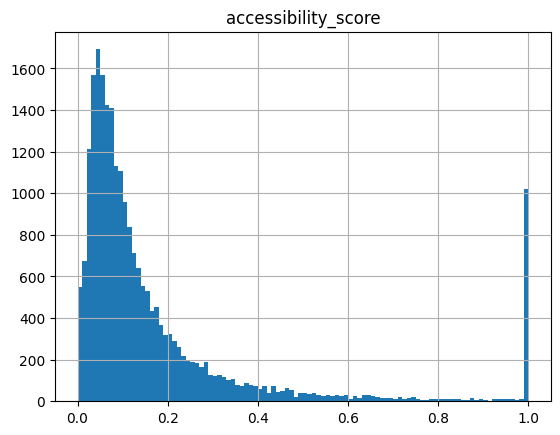

In [13]:
df_blocks.hist(column="accessibility_score", bins=100, range=(0, 1))

<Axes: >

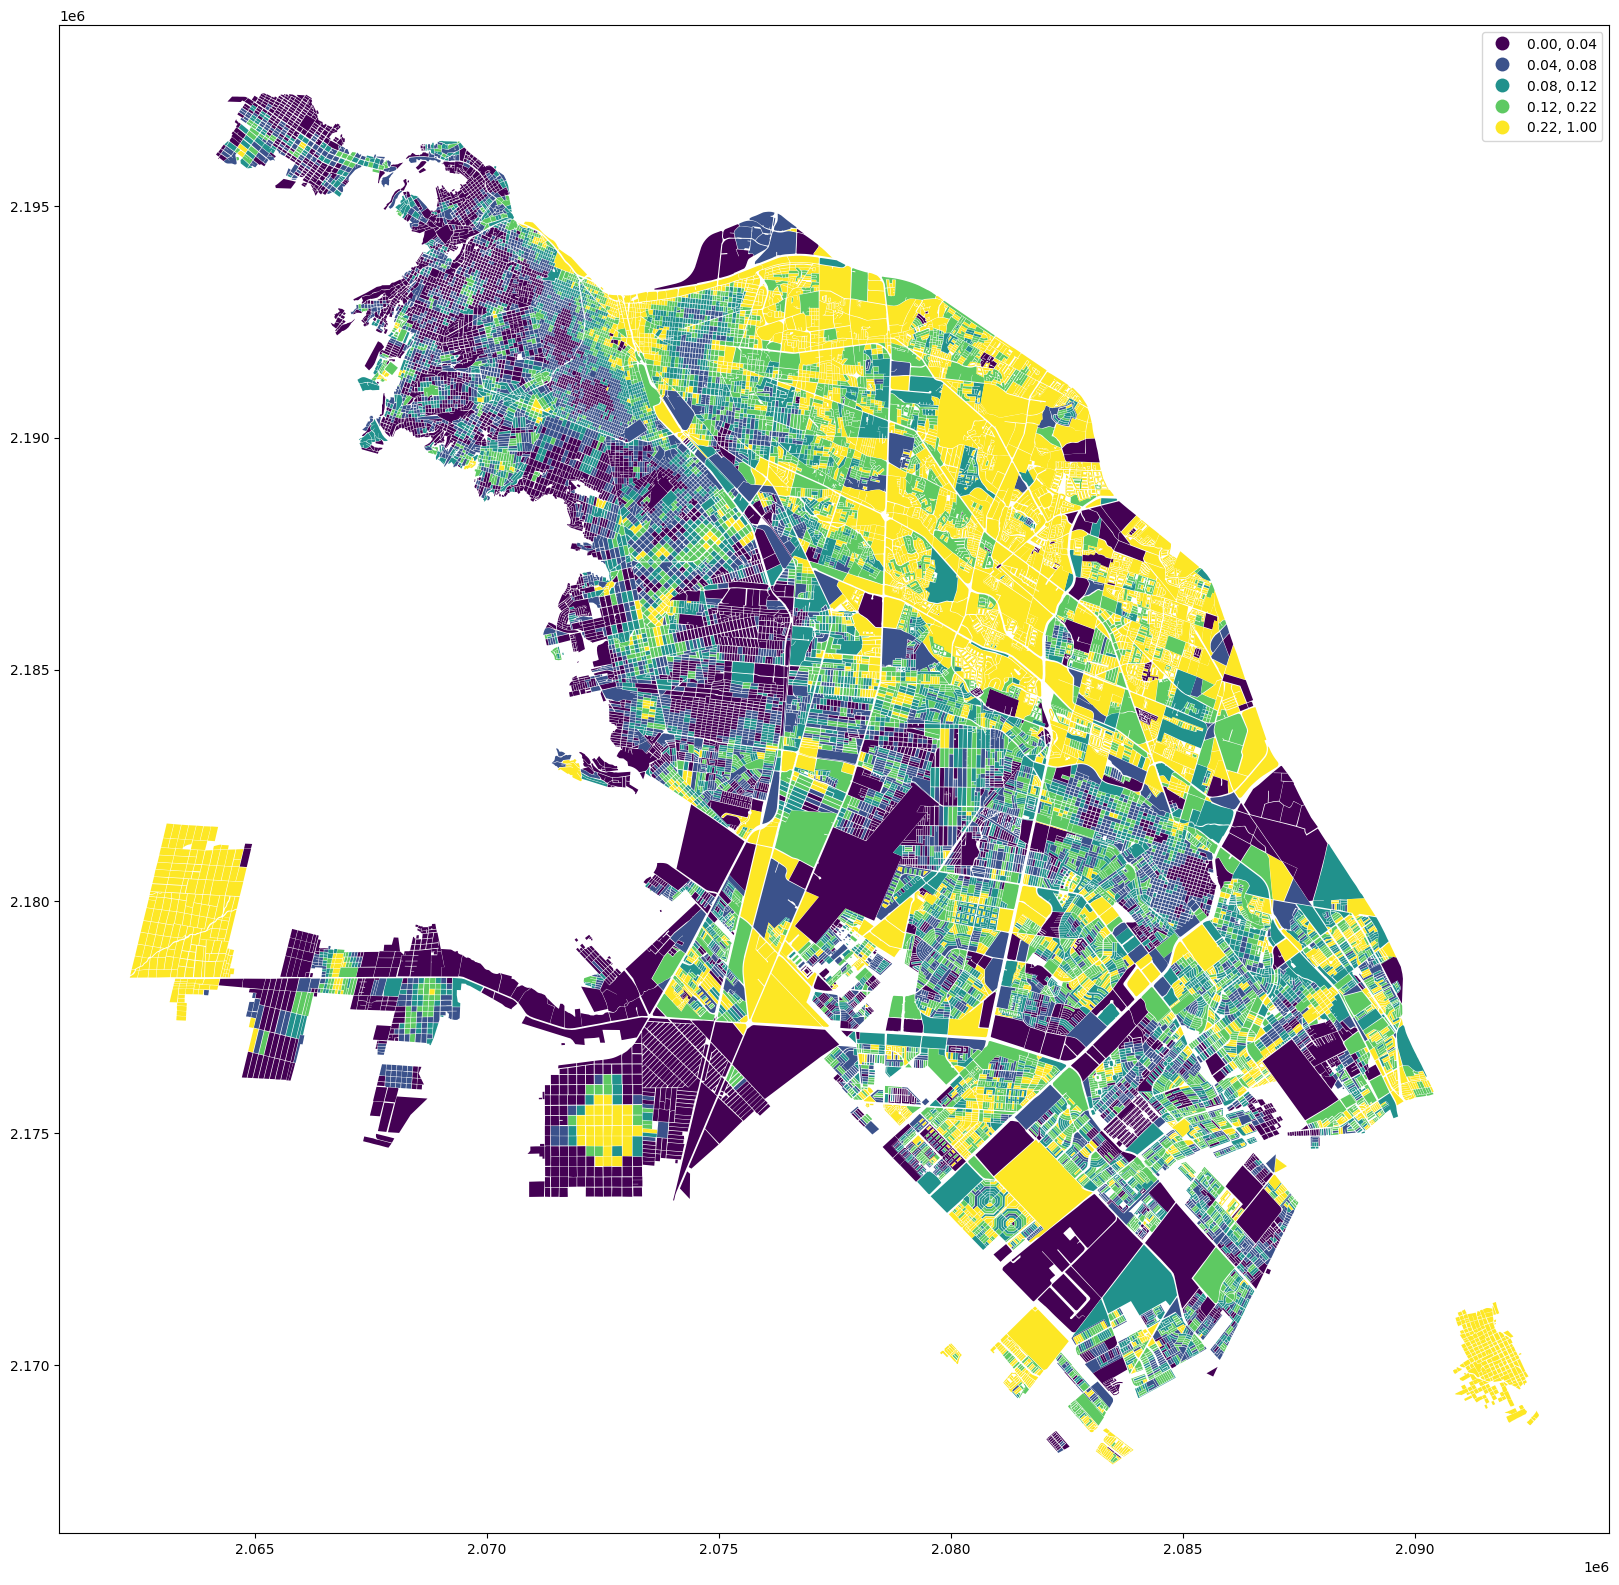

In [14]:
df_blocks.plot(
    column="accessibility_score",
    scheme="quantiles",
    k=5,
    legend=True,
    figsize=(20, 20),
)

In [15]:
df_agebs = df_blocks.groupby("CVEGEO_AGEB").agg(
    {
        "accessibility_score": "mean",
        "tiempo_parque": "mean",
        "tiempo_clinica_hospital": "mean",
        "tiempo_preparatoria": "mean",
        "hogares_parque_15mi": "sum",
        "hogares_clinica_hospital_30mi": "sum",
        "hogares_preparatoria_30mi": "sum",
        "TVIVPARHAB": "sum",
    },
)
df_agebs["per_hogares_parque_15mi"] = df_agebs.apply(
    lambda x: x["hogares_parque_15mi"] / x["TVIVPARHAB"] if x["TVIVPARHAB"] > 0 else 0,
    axis=1,
).clip(0, 1)
df_agebs["per_hogares_clinica_hospital_30mi"] = df_agebs.apply(
    lambda x: x["hogares_clinica_hospital_30mi"] / x["TVIVPARHAB"]
    if x["TVIVPARHAB"] > 0
    else 0,
    axis=1,
).clip(0, 1)
df_agebs["per_hogares_preparatoria_30mi"] = df_agebs.apply(
    lambda x: x["hogares_preparatoria_30mi"] / x["TVIVPARHAB"]
    if x["TVIVPARHAB"] > 0
    else 0,
    axis=1,
).clip(0, 1)
df_geom_agebs = df_geom_agebs.join(df_agebs.drop(columns=["TVIVPARHAB"]))
df_agebs

,accessibility_score,tiempo_parque,tiempo_clinica_hospital,tiempo_preparatoria,hogares_parque_15mi,hogares_clinica_hospital_30mi,hogares_preparatoria_30mi,TVIVPARHAB,per_hogares_parque_15mi,per_hogares_clinica_hospital_30mi,per_hogares_preparatoria_30mi
CVEGEO_AGEB,,,,,,,,,,,
0803700010401,0.315268,4.909314,22.959626,13.637388,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0803700010416,0.426881,1.520939,12.551153,16.201644,916.0,1832.0,916.0,916.0,1.0,1.0,1.0
0803700010435,0.663785,1.755097,23.682126,13.341551,197.0,314.0,197.0,197.0,1.0,1.0,1.0
0803700010454,0.320152,2.953254,4.262295,10.563969,887.0,1774.0,887.0,887.0,1.0,1.0,1.0
0803700010469,0.313448,5.495366,4.695678,5.852397,259.0,518.0,259.0,259.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
0803706356472,1.000000,0.000000,0.000000,0.000000,177.0,354.0,177.0,177.0,1.0,1.0,1.0
0803706356519,1.000000,0.000000,0.000000,0.000000,22.0,44.0,22.0,22.0,1.0,1.0,1.0
0803706356523,1.000000,0.000000,0.000000,0.000000,28.0,56.0,28.0,28.0,1.0,1.0,1.0


<Axes: >

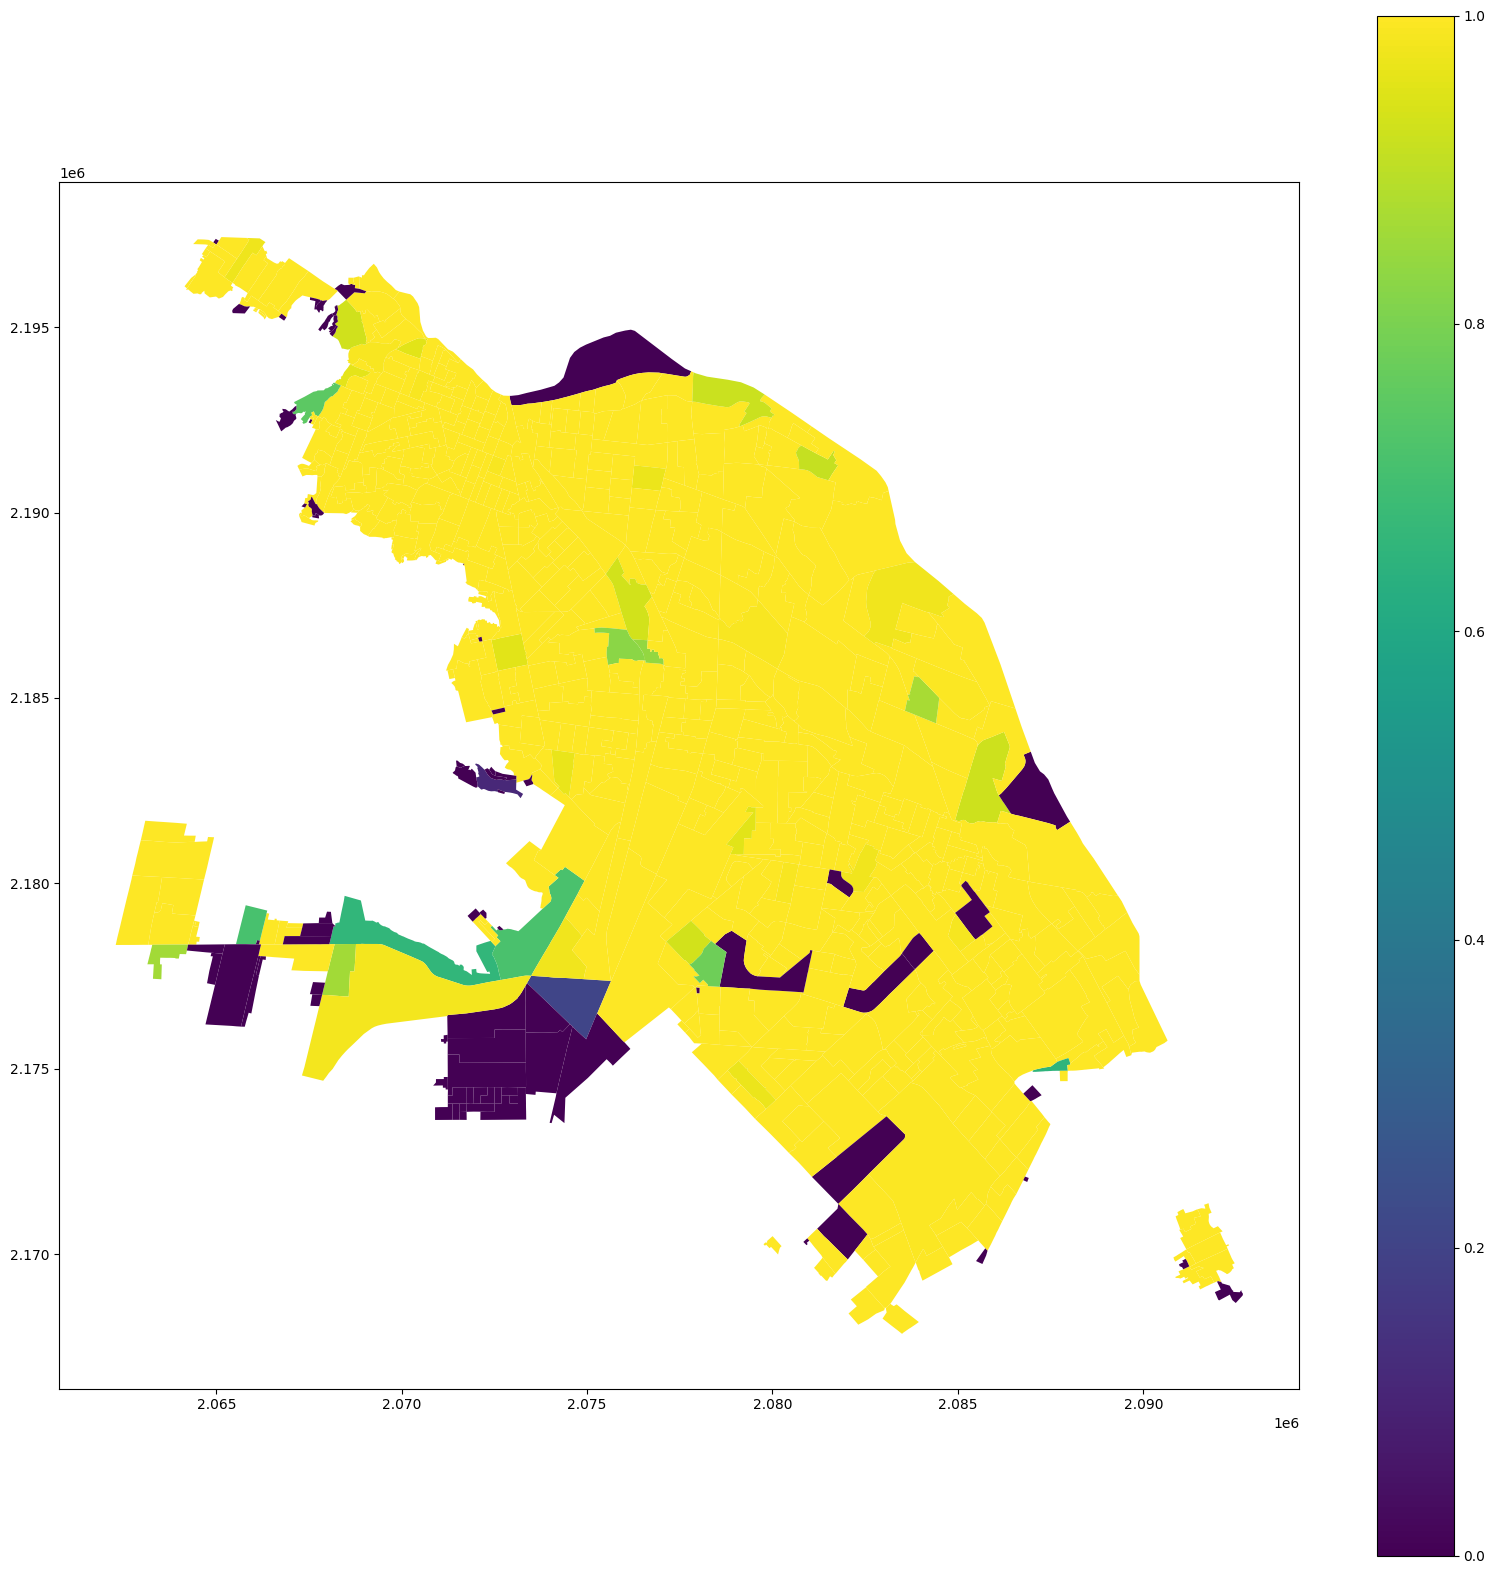

In [16]:
df_geom_agebs.plot(
    column="per_hogares_parque_15mi",
    cmap="viridis",
    legend=True,
    figsize=(20, 20),
)

/Users/rodolfofigueroa/Documents/NAD/.venv/lib/python3.12/site-packages/mapclassify/classifiers.py:1767: UserWarning: Not enough unique values in array to form 10 classes. Setting k to 3.
  self.bins = quantile(y, k=k)


<Axes: >

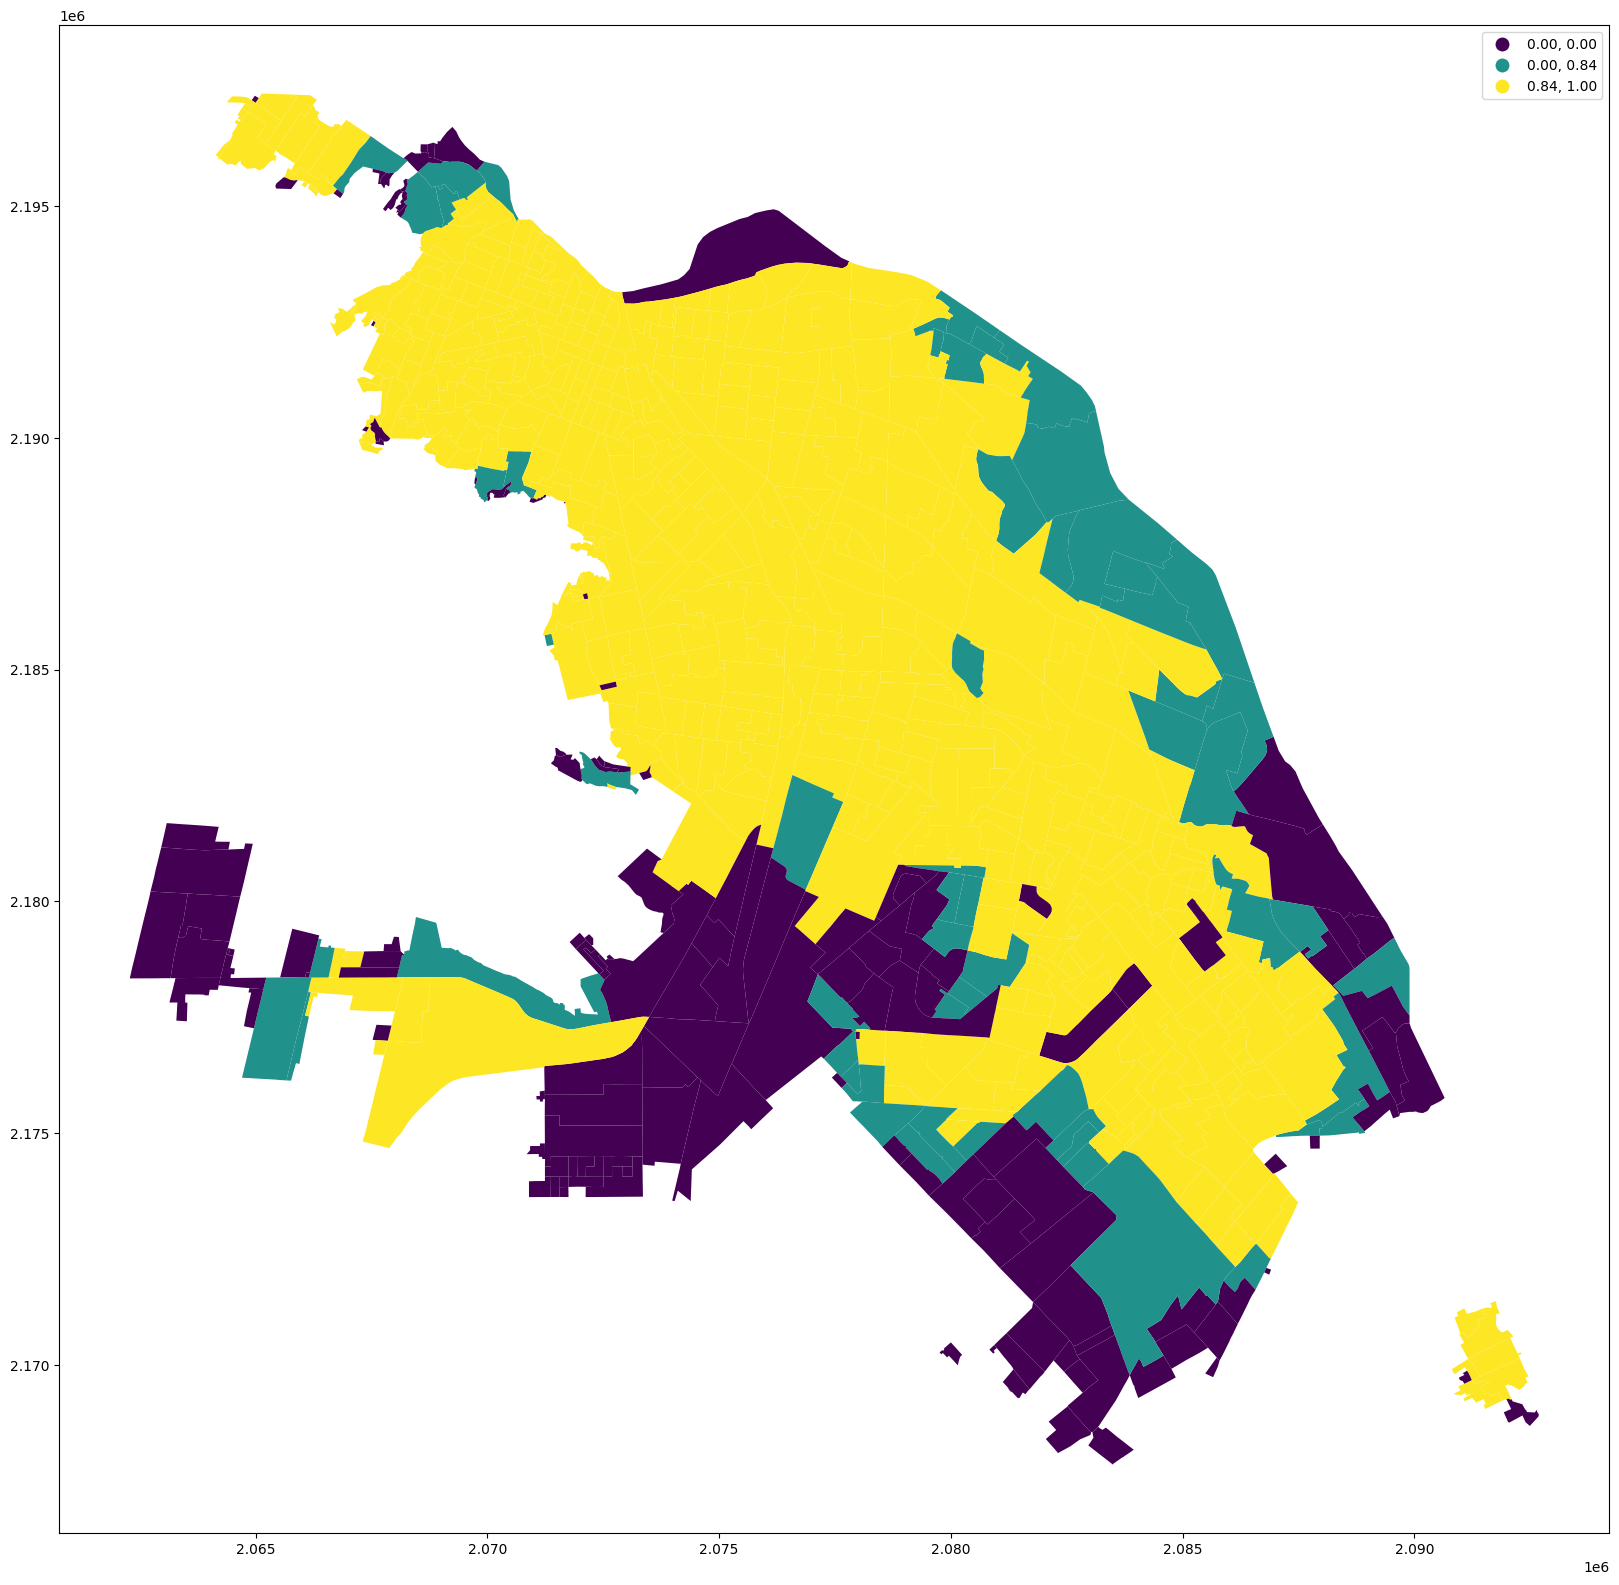

In [17]:
df_geom_agebs.plot(
    column="per_hogares_preparatoria_30mi",
    scheme="quantiles",
    k=10,
    legend=True,
    figsize=(20, 20),
)

In [18]:
df_blocks

,origin_id,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry,CVEGEO_AGEB,...,VPH_REFRI,VPH_LAVAD,VPH_HMICRO,accessibility_score,tiempo_parque,tiempo_clinica_hospital,tiempo_preparatoria,hogares_parque_15mi,hogares_clinica_hospital_30mi,hogares_preparatoria_30mi
CVEGEO,,,,,,,,,,,,,,,,,,,,,
0803700018286011,44535,08,037,0001,8286,011,Urbana,Típica,"POLYGON ((2082431.299 2168169.073, 2082318.174...",0803700018286,...,7.0,5.0,4.0,0.045446,3.265956,34.823232,60.000000,7.0,NaN,NaN
0803700012342009,58481,08,037,0001,2342,009,Urbana,Típica,"POLYGON ((2085702.349 2182812.041, 2085696.476...",0803700012342,...,0.0,0.0,0.0,1.000000,1.336644,53.034914,27.251039,0.0,NaN,0.0
0803700012342042,21654,08,037,0001,2342,042,Urbana,Típica,"POLYGON ((2085612.952 2182637.128, 2085623.06 ...",0803700012342,...,0.0,0.0,0.0,0.331856,0.856488,60.000000,60.000000,0.0,NaN,NaN
080370001845A001,42242,08,037,0001,845A,001,Urbana,Típica,"POLYGON ((2086867.39 2171955.722, 2086786.146 ...",080370001845A,...,0.0,0.0,0.0,0.024924,4.893396,22.617636,32.349144,0.0,0.0,NaN
0803700018286003,44580,08,037,0001,8286,003,Urbana,Típica,"POLYGON ((2082405.614 2168375.778, 2082329.831...",0803700018286,...,18.0,13.0,10.0,0.039987,3.609156,35.166431,60.000000,22.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0803700012889003,29522,08,037,0001,2889,003,Urbana,Típica,"POLYGON ((2073663.411 2174914.846, 2073692.753...",0803700012889,...,0.0,0.0,0.0,0.047287,41.227752,60.000000,60.000000,NaN,NaN,NaN
0803700014739029,29540,08,037,0001,4739,029,Urbana,Típica,"POLYGON ((2073146.676 2175160.644, 2073344.395...",0803700014739,...,NaN,NaN,NaN,0.250134,45.775523,60.000000,60.000000,NaN,NaN,NaN
0803700012889005,29540,08,037,0001,2889,005,Urbana,Típica,"POLYGON ((2073356.333 2175099.392, 2073669.321...",0803700012889,...,NaN,NaN,NaN,0.250134,45.775523,60.000000,60.000000,NaN,NaN,NaN


<Axes: >

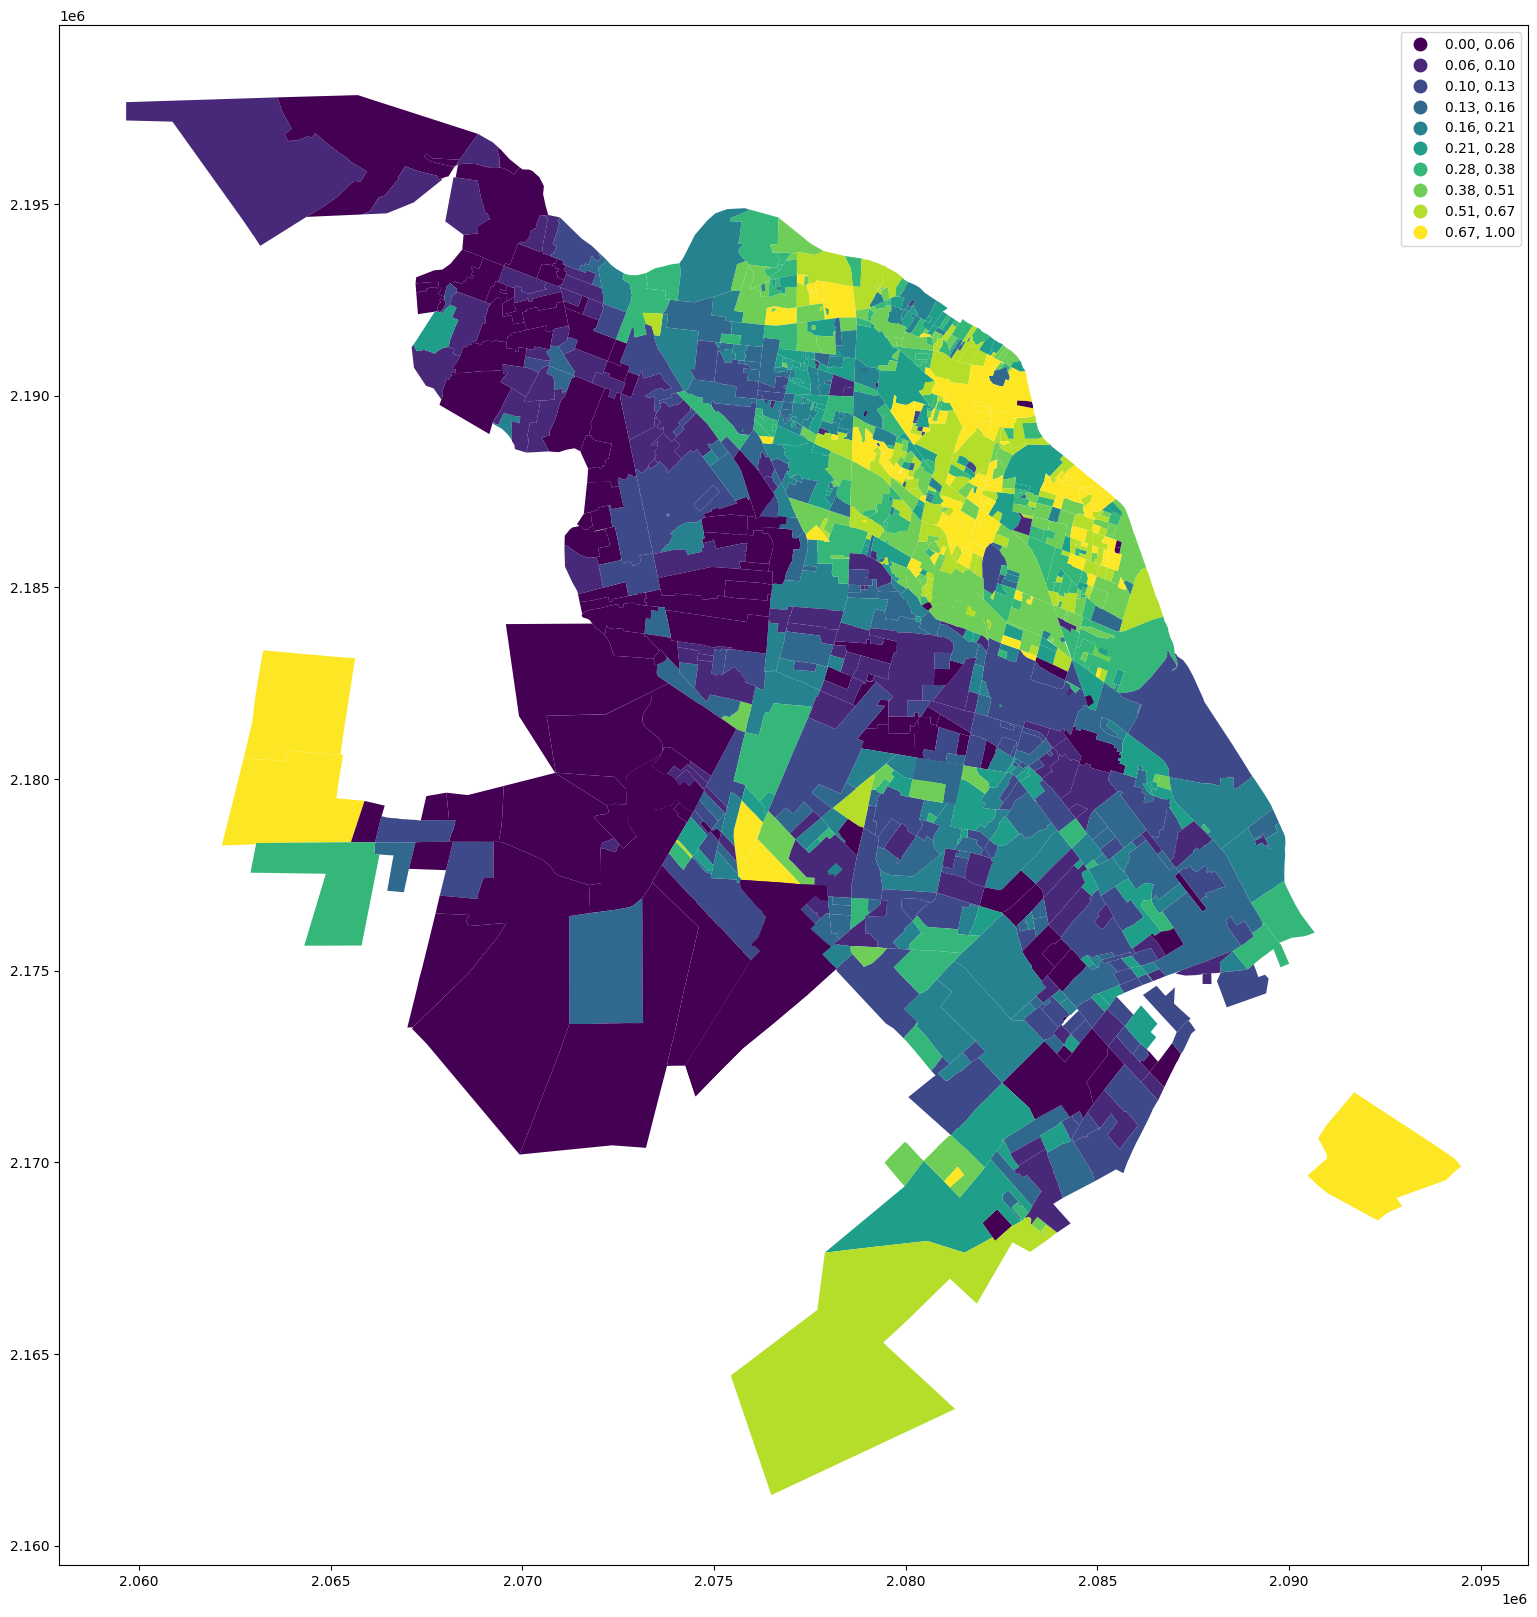

In [19]:
df_colonias = gpd.read_file(data_path / "datos/colonias_raw.geojson").to_crs(
    "EPSG:6372",
)
df_colonias = df_colonias.sjoin(df_blocks, how="left")
df_colonias = df_colonias.groupby("ID").agg(
    {
        "accessibility_score": "mean",
        "tiempo_parque": "mean",
        "tiempo_clinica_hospital": "mean",
        "tiempo_preparatoria": "mean",
        "hogares_parque_15mi": "sum",
        "hogares_clinica_hospital_30mi": "sum",
        "hogares_preparatoria_30mi": "sum",
        "TVIVPARHAB": "sum",
        "geometry": "first",
    },
)
df_colonias = gpd.GeoDataFrame(df_colonias, geometry="geometry", crs="EPSG:6372")
df_colonias["per_hogares_parque_15mi"] = df_colonias.apply(
    lambda x: x["hogares_parque_15mi"] / x["TVIVPARHAB"] if x["TVIVPARHAB"] > 0 else 0,
    axis=1,
).clip(0, 1)
df_colonias["per_hogares_clinica_hospital_30mi"] = df_colonias.apply(
    lambda x: x["hogares_clinica_hospital_30mi"] / x["TVIVPARHAB"]
    if x["TVIVPARHAB"] > 0
    else 0,
    axis=1,
).clip(0, 1)
df_colonias["per_hogares_preparatoria_30mi"] = df_colonias.apply(
    lambda x: x["hogares_preparatoria_30mi"] / x["TVIVPARHAB"]
    if x["TVIVPARHAB"] > 0
    else 0,
    axis=1,
).clip(0, 1)
df_colonias.plot(
    column="accessibility_score",
    scheme="quantiles",
    k=10,
    legend=True,
    figsize=(20, 20),
)

<Axes: >

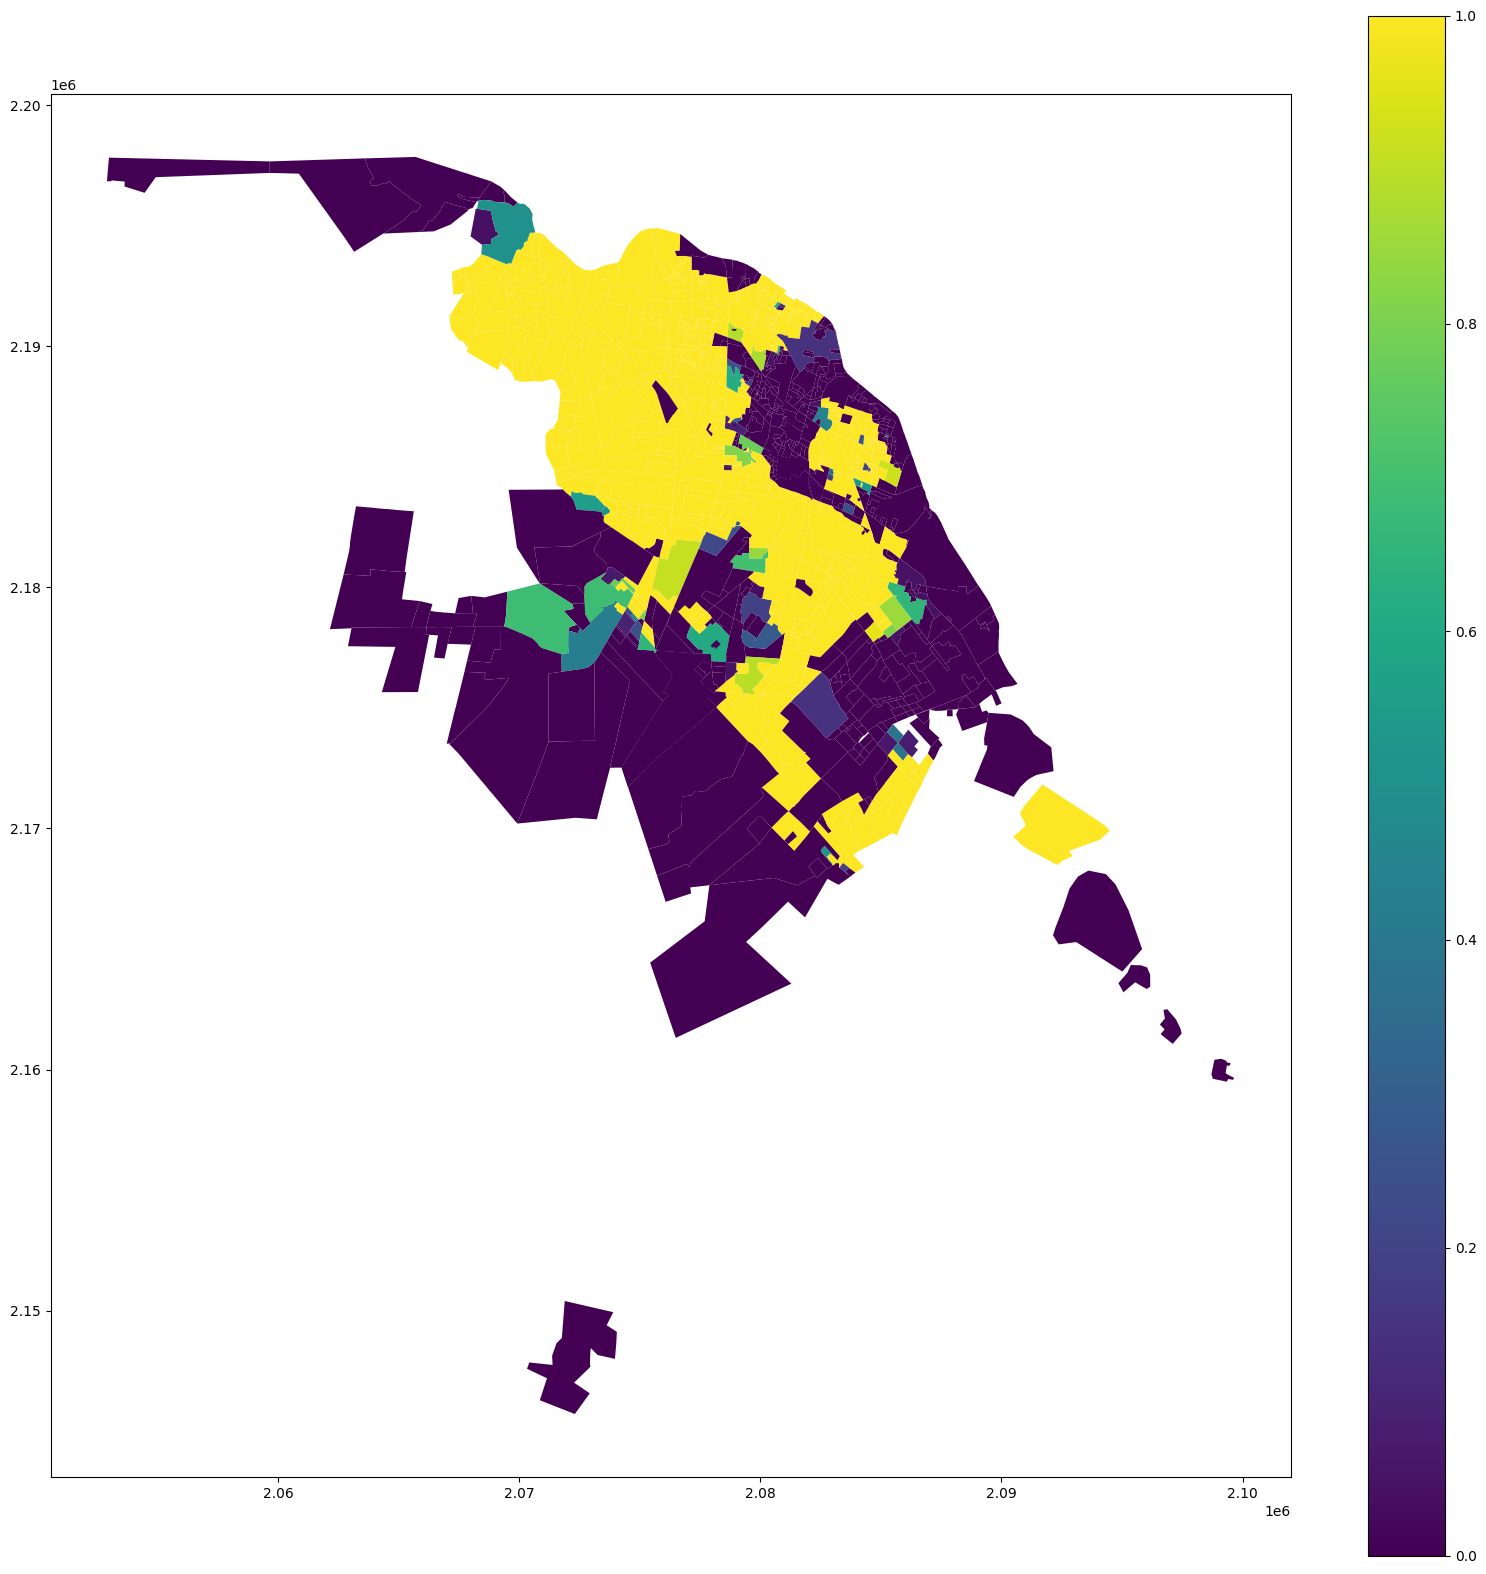

In [20]:
df_colonias.plot(
    column="per_hogares_clinica_hospital_30mi",
    legend=True,
    figsize=(20, 20),
)

In [21]:
cols_keep = [
    "accessibility_score",
    "tiempo_parque",
    "tiempo_clinica_hospital",
    "tiempo_preparatoria",
    "per_hogares_parque_15mi",
    "per_hogares_clinica_hospital_30mi",
    "per_hogares_preparatoria_30mi",
]
df_geom_agebs[cols_keep].reset_index().to_csv(results_path / "accessibility_agebs.csv")
df_colonias[cols_keep].reset_index().to_csv(results_path / "accessibility_colonias.csv")